In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow.data import Dataset
import keras
%matplotlib inline  
import os
from tensorflow.keras import layers
from tensorflow.keras import backend as K

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
PATH = './drive/My Drive/ФМИ - магистър/NLP/Question-Answering'

In [0]:
flatten = lambda l: [item for sublist in l for item in sublist]

In [0]:
df = pd.read_json(os.path.join(PATH, 'dev.json'))

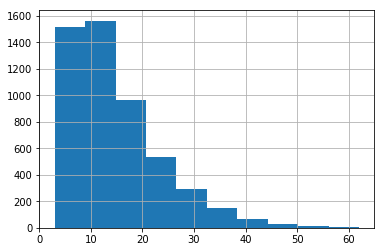

In [6]:
supports_count = df[['supports']].apply(lambda x: len(x[0]),axis=1)
supports_count.hist()

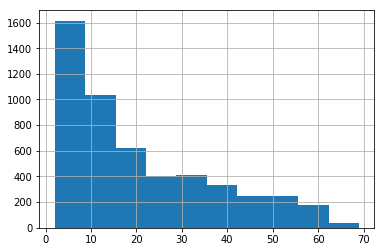

In [7]:
candidates_count = df[['candidates']].apply(lambda x: len(x[0]),axis=1)
candidates_count.hist()

In [0]:
def tokenizer_query(data, column):
    tokenizer = tf.keras.preprocessing.text.Tokenizer()
    tokenizer.fit_on_texts(data[column])
    return tokenizer, tokenizer.word_index

train_all = pd.read_json(os.path.join(PATH, 'train.json'))
train_all['supports'] = train_all[['supports']].apply(lambda x: '\n'.join(x[0]), axis=1)
query_tokenizer, query_vocabulary = tokenizer_query(train_all, 'query')
supports_tokenizer, supports_vocabulary = tokenizer_query(train_all, 'supports')
del train_all

In [0]:
tf.reset_default_graph()

In [10]:
class InputGenerator:
  column_types = [
    ('id', tf.string),
    ('annotations', tf.string),
    ('candidates', tf.int32),
    ('query', tf.int32),
    ('supports', tf.int32),
  ]
  output_types = tuple([x[1] for x in column_types])

  def __init__(self, tokenizers):
    self.query_tokenizer = tokenizers['query']
    self.supports_tokenizer = tokenizers['supports']

  def input_generator_gen(self, df):
    def gen():
      for index, row in df.iterrows():
        candidates = flatten(self.supports_tokenizer.texts_to_sequences(['\n'.join(row['candidates'])]))
        query = flatten(self.query_tokenizer.texts_to_sequences([row['query']]))
        supports = flatten(self.supports_tokenizer.texts_to_sequences(['\n'.join(row['supports'])]))
        answer = flatten(self.supports_tokenizer.texts_to_sequences([row['answer']]))
        yield ([row['id']], row['annotations'],  candidates, query, supports), answer

    return gen, (self.output_types, tf.int32)

batch_size = 10
tokenizers = {'query': query_tokenizer, 'supports': supports_tokenizer}
dataset = tf.data.Dataset.from_generator(*InputGenerator(tokenizers).input_generator_gen(df))
dataset = dataset.repeat()
padded_shapes = ((tf.TensorShape([None]),
                 tf.TensorShape([None, 2]),
                 tf.TensorShape([None]),
                 tf.TensorShape([None]),
                 tf.TensorShape([None])),
                 tf.TensorShape([None]))
# Commented out for debugging purposes
# dataset = dataset.shuffle(10)
dataset = dataset.take(20)
dataset = dataset.padded_batch(batch_size, padded_shapes=padded_shapes)
batch = dataset.make_one_shot_iterator().get_next()

with tf.Session() as sess:
  sess.run([tf.local_variables_initializer(), tf.tables_initializer()])
  b = sess.run(batch)
b

Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, use
    tf.py_function, which takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    


((array([[b'WH_dev_0'],
         [b'WH_dev_1'],
         [b'WH_dev_2'],
         [b'WH_dev_3'],
         [b'WH_dev_4'],
         [b'WH_dev_5'],
         [b'WH_dev_6'],
         [b'WH_dev_7'],
         [b'WH_dev_8'],
         [b'WH_dev_9']], dtype=object), array([[[b'follows', b'single'],
          [b'follows', b'multiple'],
          [b'follows', b'multiple']],
  
         [[b'follows', b'multiple'],
          [b'follows', b'single'],
          [b'follows', b'single']],
  
         [[b'not_follow', b''],
          [b'not_follow', b''],
          [b'likely', b'single']],
  
         [[b'likely', b'multiple'],
          [b'not_follow', b''],
          [b'not_follow', b'']],
  
         [[b'follows', b'single'],
          [b'follows', b'single'],
          [b'follows', b'multiple']],
  
         [[b'follows', b'single'],
          [b'follows', b'multiple'],
          [b'not_follow', b'']],
  
         [[b'follows', b'multiple'],
          [b'follows', b'multiple'],
          [b'likely', b

In [11]:
# This is the first answer, just checking if it matches with the result from the padded batch
# it should show
# from the padded batch - `[  234,   286,     0,     0,     0,     0]`
# after executing this row - `[[234, 286]]`
supports_tokenizer.texts_to_sequences(["german empire"]),supports_vocabulary['german'], supports_vocabulary['empire']

([[234, 286]], 234, 286)

https://stackoverflow.com/questions/46135499/how-to-properly-combine-tensorflows-dataset-api-and-keras

In [0]:
params = {
    'query_embedding_size': 50,
    'supports_embedding_size': 50,
    'lstm_units': 10,
    'dense_SA_size': 100,
    'vocab_size_context': len(supports_vocabulary),
}

Някакви важни, чисто имплементационни детайли:

model_to_estimator https://stackoverflow.com/questions/48136804/tf-estimator-train-throws-as-list-is-not-defined-on-an-unknown-tensorshape

why the shape of the input is None: https://datascience.stackexchange.com/questions/26366/training-an-rnn-with-examples-of-different-lengths-in-keras

LSTM - return_sequences, return_state

(Writing models)[https://www.tensorflow.org/alpha/guide/keras/custom_layers_and_models#the_model_class]
reduce_sum is tf.keras.backend.sum

In [0]:
def expand_dims_axis(axis):
  def expand_dims(x):
    return tf.expand_dims(x, axis=axis)
  return expand_dims

def reduce_sum_axis(axis):
  def reduce_sum(x):
    return tf.reduce_sum(x, axis)
  return reduce_sum

ExpandDims_1 = layers.Lambda(expand_dims_axis(1))
ExpandDims_2 = layers.Lambda(expand_dims_axis(2))

Exp = layers.Lambda(lambda v: tf.exp(v))

ReduceSum = layers.Lambda(reduce_sum_axis(1))

Max = layers.Lambda(lambda x: tf.reduce_max(x, axis=1))

Divide = layers.Lambda(lambda vs: vs[0] / vs[1])


In [0]:
# Input layers
input_query = layers.Input(shape=(None,))
input_context = layers.Input(shape=(None,))

# Embeddings for the query and the context
query_embedding = layers.Embedding(input_dim=len(query_vocabulary),
                                   output_dim=params['query_embedding_size'])(input_query)

context_embedding = layers.Embedding(input_dim=params['vocab_size_context'],
                                     output_dim=params['supports_embedding_size'])(input_context)
## TODO: Load ELMo embeddings and concatenate them here!

# Reasoning cells Layer
num_reasoning_cells = 1

# Emulating multi-hop reasoning
## Positive integer, dimensionality of the output space.
units = params['lstm_units']
c_t = context_embedding

for t in range(num_reasoning_cells):
    u_t = layers.Bidirectional(layers.LSTM(units,
                                           dropout=0.25,
                                           return_sequences=False,
                                           recurrent_dropout=0.1))(c_t)
    v_t = layers.Bidirectional(layers.LSTM(units,
                                           dropout=0.25,
                                           return_sequences=False,
                                           recurrent_dropout=0.1))(query_embedding)
    # return_sequences: Boolean.
    # Whether to return the last output. in the output sequence, or the full sequence.
    # При нас e False, тъй като искаме да получим encodings/embeddings на целите query & context.

    w_1_t = layers.Dense(units=1, use_bias=False)
    w_2_t = layers.Dense(units=1, use_bias=False)
    w_3_t = layers.Dense(units=1, use_bias=False)

    i_s = w_1_t(u_t)
    j_s = ExpandDims_2(w_2_t(v_t))
    s_t = layers.Add()([i_s, j_s, w_3_t(layers.Multiply()([u_t,  v_t]))])

    s_t_exp = Exp(s_t)
    p_ij_t = Divide((s_t_exp, ReduceSum(s_t_exp)))
    c_q = ReduceSum(layers.Multiply()([p_ij_t, v_t]))

    # query-to-context attention vector
    m_t = Max(s_t)
    m_t_exp = Exp(m_t)
    p_i_t = Divide((m_t_exp, ReduceSum(m_t_exp)))

    q_c_t = ReduceSum(layers.Multiply()([p_i_t, u_t]))

    c_t = layers.Concatenate(axis=1)([u_t,
                                     c_q,
                                     layers.Multiply()([u_t, c_q]),
                                     layers.Multiply()([q_c_t, c_q])])
    break

c_k = c_t
# Self Attention Layer
# expand_dims го използваме, за да получим един timestep.
c_SA = layers.Dense(params['dense_SA_size'],)(c_t)
c_SA = ExpandDims_1(c_SA)
c_SA = layers.Bidirectional(layers.LSTM(units,
                                       return_sequences=False,
                                       dropout=0.25,
                                       recurrent_dropout=0.1))(c_SA)

w_4 = layers.Dense(units=1, use_bias=False)
w_5 = layers.Dense(units=1, use_bias=False)
w_6 = layers.Dense(units=1, use_bias=False)

S = layers.Add()([
    w_4(c_SA),
    w_5(ExpandDims_2(c_SA)),
    w_6(layers.Multiply()([c_SA, ExpandDims_2(c_SA)]))
    ])
S_exp = Exp(S)
p = Divide((S_exp, ReduceSum(S_exp)))

c_prim = ReduceSum(layers.Multiply()([p, c_SA]))
alltogether = layers.concatenate([c_prim, c_SA, layers.Multiply()([c_prim, c_SA])], axis=1)
# one time step
alltogether = ExpandDims_1(alltogether)
units = 4 * params['lstm_units']
c_second = layers.Bidirectional(layers.LSTM(units,
                                   return_sequences=False,
                                   dropout=0.25,
                                   recurrent_dropout=0.1))(alltogether)
c = layers.Add()([c_k, c_second])

# Decoder
# currently generating only one timestep
# x_t - lstm_output
decoder_input = ExpandDims_1(c)
x_t, hidden_state, cell_state = layers.LSTM(units,
                                            return_state=True,
                                            dropout=0.25,
                                            recurrent_dropout=0.1)(decoder_input)
logits = layers.Dense(params['vocab_size_context'],
                      activation=keras.activations.softmax)(hidden_state)

inputs = [input_query, input_context]
model = tf.keras.Model(inputs=inputs, outputs=logits)

model.compile('sgd',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              # List of metrics to monitor
              metrics=[tf.keras.metrics.CategoricalAccuracy()])

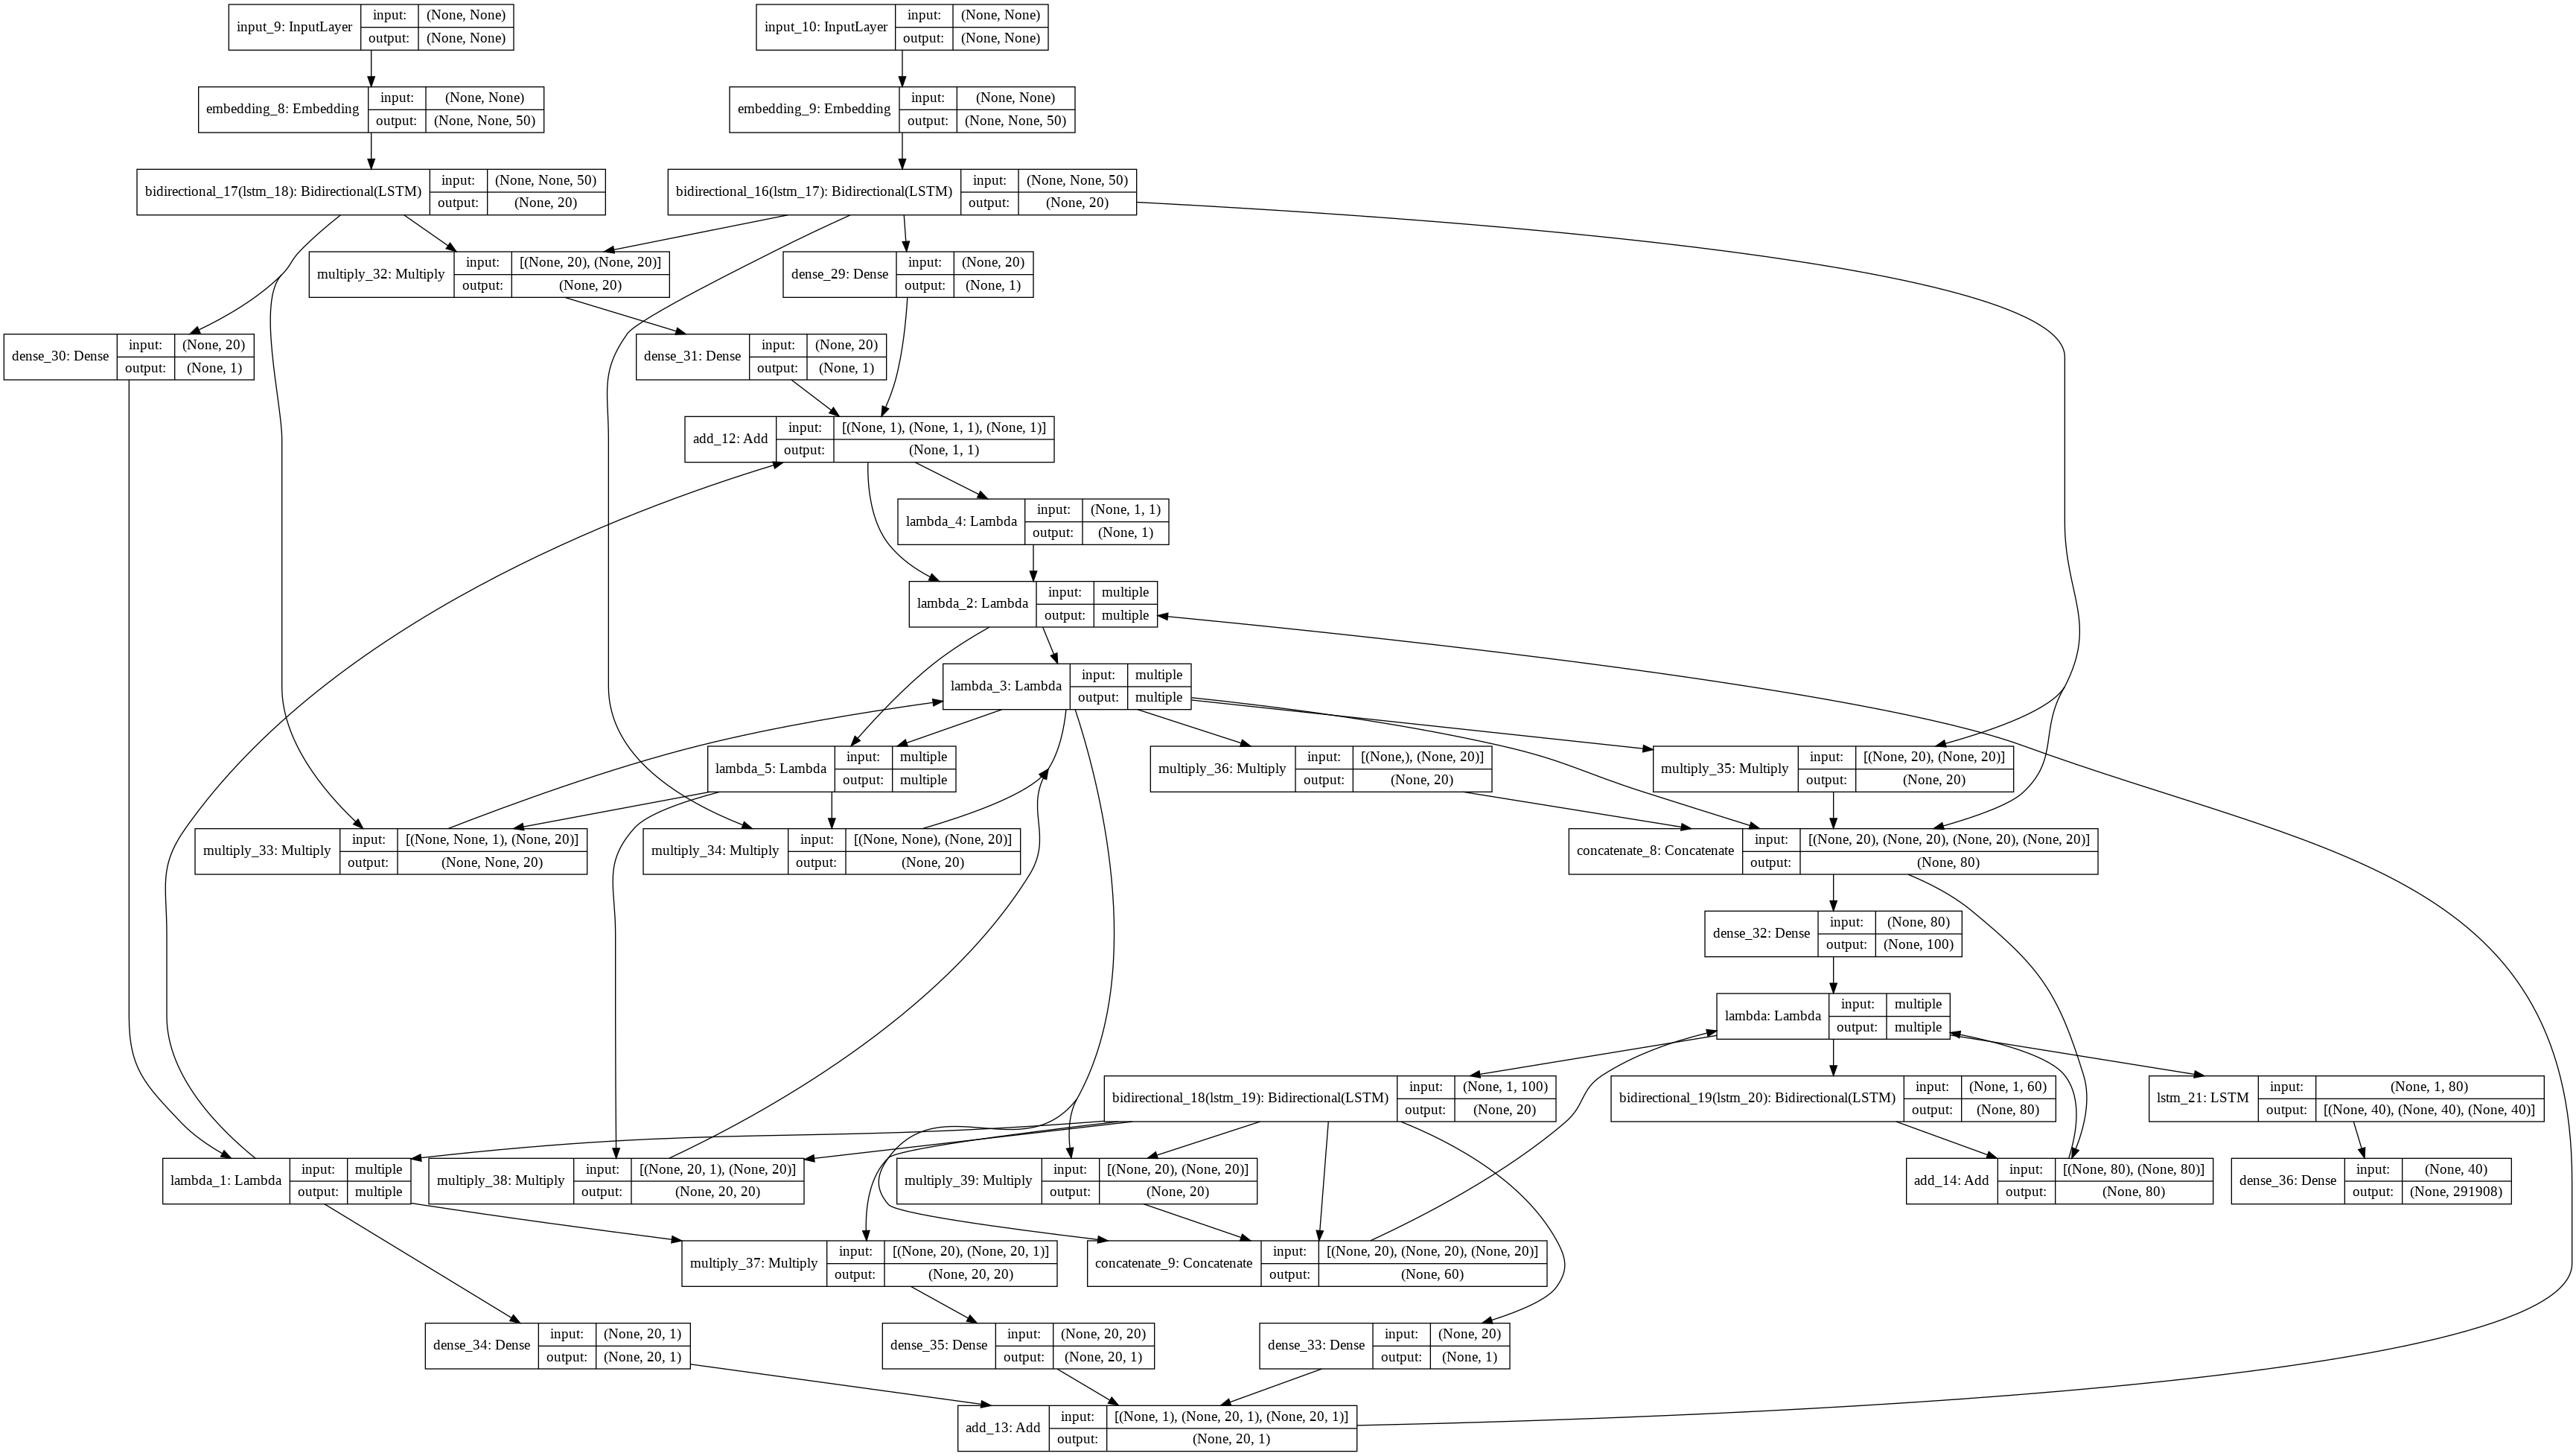

In [25]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
from IPython.display import Image
Image(retina=True, filename='model.png')

In [46]:
batch_size = 10

dataset = tf.data.Dataset.from_generator(*InputGenerator(tokenizers).input_generator_gen(df))
dataset = dataset.repeat()
dataset = dataset.padded_batch(batch_size, padded_shapes=padded_shapes)
batch = dataset.make_one_shot_iterator().get_next()
# Размерността тук е `[batch_size, брой на думи в отговора (в случая e padded answer), vocab_size]
(_, _, x_candidates, x_query, x_supports), y = batch

input_onehot_labels_answer = y
OneHot = layers.Lambda(lambda v: K.one_hot(v,
                                 num_classes=params['vocab_size_context']))
input_onehot_labels_answer = OneHot(input_onehot_labels_answer)

# Getting only the first word from the answer
getFirstWord = layers.Lambda(lambda v: tf.slice(v,
                                [0, 0, 0],
                                [-1, 1, -1]))
onehot_labels_answer = getFirstWord(input_onehot_labels_answer)
onehot_labels_answer = tf.reshape(onehot_labels_answer, [-1, params['vocab_size_context']])
x_query, onehot_labels_answer

(<tf.Tensor 'IteratorGetNext_16:3' shape=(?, ?) dtype=int32>,
 <tf.Tensor 'Reshape_12:0' shape=(?, 291908) dtype=float32>)

In [47]:
history = model.fit(x=(x_query, x_supports), y=onehot_labels_answer,
                    epochs=3,
                    steps_per_epoch=1)

Epoch 1/3


InvalidArgumentError: ignored

LSTM in keras:
https://stackoverflow.com/questions/49313650/how-could-i-get-both-the-final-hidden-state-and-sequence-in-a-lstm-layer-when-us
https://machinelearningmastery.com/return-sequences-and-return-states-for-lstms-in-keras/

Work to be done:
- maybe it's better to have one vocab for the query and the context.
- rework the decoder (now generating only one word instead of phrases for the answer), maybe not generating the distribution over the whole vocab but the suggested answers? Or after generating over the whole, just focus on the suggested ones?
- check all calculations if something is wrong

In [0]:
class GMH_WO_COMMON_SENSE(tf.keras.Model):

  def __init__(self):
    super(GMH_WO_COMMON_SENSE, self).__init__()
    # TODO: define layers here?
    pass

  def call(self, inputs, training=False):
    pass